# Gradient Boost Model


## Einleitung

boosting controls both the aspects (bias & variance). It combines a set of weak learners and delivers improved prediction accuracy.

The overall parameters can be divided into 3 categories:

  -  Tree-Specific Parameters: These affect each individual tree in the model.
  -  Boosting Parameters: These affect the boosting operation in the model.
  -  Miscellaneous Parameters: Other parameters for overall functioning.
  
  
  Quelle:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [3]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split

from scipy.stats import kurtosis
from scipy.stats import skew

pd.options.display.precision = 10

## Umgebungsvariablen

In [4]:
#feature generated 24.03.2019
earthquake_daten = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/earthquake_data/'''
feature_62900_94 = 'Features_62900-94.csv'
feature_41934_94 = 'Features_41934_94.csv'
Features_4194_94 = 'Features_4194_94.csv'

# Feature laden

In [5]:
train_data = pd.read_csv(earthquake_daten+feature_41934_94)

In [6]:
feature_data = train_data.iloc[:,1:95]
time_to_failure = np.array(train_data.iloc[:,-1])

## Feature Filtern

In [22]:
items_to_filter = ['']

In [23]:
filtered_feature_data = feature_data.filter(items=items_to_filter)

In [24]:
feature_data = filtered_feature_data

## Training / Testdaten vorbereiten

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_data,
    time_to_failure,
    random_state=0,
    test_size=0.25)

# Model Workbench

## Imports

In [7]:
# Scaler


# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Modell
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Quelle: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [8]:
def getMostImportendFeatuers(feat_imp, topAmount):
    '''Gibt die wichtigsten Features zurück. Wird benötigt, um die Trainingsdaten und Testdaten 
    anhand Featuers zu filtern.'''
    i = 0
    featureFilter = list()
    for feature in feat_imp:
        featureFilter.append(feature)
        i +=1
        if i >= topAmount:
            break
    return featureFilter

In [11]:
def modelfit(alg, dtrain, time_to_failure, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain, time_to_failure)
      
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, time_to_failure, cv=cv_folds, scoring='neg_mean_absolute_error',n_jobs=-1)
    
    #Print model report:
    print("\nModel Report")
    print("MAE train data: %.4g" % mean_absolute_error(time_to_failure, dtrain_predictions)) 
    
    if performCV:
        print("CV Score MAE: \nMean %.7g \nStd %.7g \nMin %.7g \nMax %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, dtrain.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances',figsize=(15,10))
        plt.ylabel('Feature Importance Score')
        plt.show()
        print('Top 30 Feature')
        print(getMostImportendFeatuers(feat_imp.index,30))

# Baseline


Model Report
MAE train data: 1.962
CV Score MAE: 
Mean -2.190147 
Std 0.4668447 
Min -2.628976 
Max -1.326725


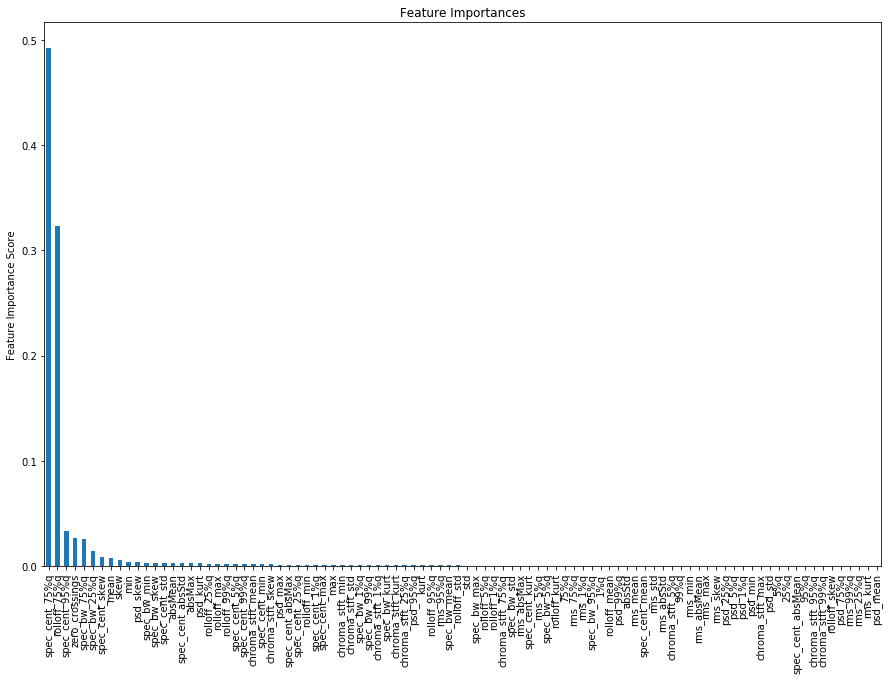

Top 30 Feature
['spec_cent_75%q', 'rolloff_75%q', 'spec_cent_95%q', 'zero_crossings', 'spec_bw_75%q', 'spec_bw_25%q', 'spec_cent_skew', 'mean', 'skew', 'min', 'psd_skew', 'spec_bw_min', 'spec_bw_skew', 'spec_cent_std', 'absMean', 'spec_cent_absStd', 'absMax', 'psd_kurt', 'rolloff_25%q', 'rolloff_max', 'rolloff_99%q', 'spec_cent_5%q', 'spec_cent_99%q', 'chroma_stft_mean', 'spec_cent_min', 'chroma_stft_skew', 'psd_max', 'spec_cent_absMax', 'spec_cent_25%q', 'rolloff_min']


In [12]:
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, feature_data, time_to_failure)

# Parameter Tuning

 Tune tree based and boosting parameters

## Tree based parameter

Fix learning rate and number of estimators for tuning tree-based parameters

### Determine the optimum number of trees for fix learning rate 0.1

In [93]:
param_test1 = {'n_estimators':range(20,81,10)}

Fix learning rate and number of estimators for tuning tree-based parameters
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
subsample = 0.8 : This is a commonly used used start value

In [94]:
min_samples_split = int(filtered_feature_data.shape[0]*0.008)

estimator = GradientBoostingRegressor(
            learning_rate=0.1, 
            min_samples_split=500,
            min_samples_leaf=50,
            max_depth=8,
            max_features='sqrt',
            subsample=0.8,
            random_state=10)

gsearch1 = GridSearchCV(
    estimator = estimator,
    param_grid = param_test1, 
    scoring='neg_mean_absolute_error',
    iid=False,
    n_jobs=-1,
    cv=5)
                        
gsearch1.fit(feature_data,time_to_failure)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_sa...       subsample=0.8, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [95]:
print('Best params {}'.format(gsearch1.best_params_))
print('Best MAE score: {}'.format(gsearch1.best_score_))

Best params {'n_estimators': 30}
Best MAE score: -2.1959848493751033
